The data can be downloaded from this website: <br>
    https://www.kaggle.com/dcohen21/8anu-climbing-logbook <br>
The files should be put in the same folder as this notebook

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

In [ ]:
#import connect
from sqlite3 import connect

# Cleaning the data

## Opening the databases

In [ ]:
def qry(q, connection = connect("database.sqlite")):
    df = pd.read_sql_query(q, connection)
    connection.close
    return df

The database consists of 4 tables: users, method, grade, ascent

In [ ]:
tables = qry("SELECT name FROM sqlite_master")
tables

In [ ]:
%%time
df_user = qry("SELECT * FROM USER")# 62'593 users x 22 columns
df_grade = qry("SELECT * FROM grade")# 83 grades x 14 columns
df_method = qry("SELECT * FROM method")# 5 methods x 4 columns
df_ascent = qry("SELECT * FROM ascent")# 4'111'877 ascents x 28 columns

&&&&&&&&&&&&&&&&&&&&&&&&&

In [ ]:
df_user.columns

In [ ]:
df_grade.columns

In [ ]:
df_ascent.columns

<b> climb type: 0 = sport, 1 = boulder </b>

In [ ]:
df_method

### Extracting the relevant grades

In [ ]:
#Not all grades in df_grade appear in df_ascent
relevant_grades = set(df_ascent['grade_id'])
df_relevant_grades = pd.DataFrame(list(relevant_grades), columns = ['id'])
df_grade = pd.merge(df_grade, df_relevant_grades, on = 'id')

In [ ]:
%%time
#Set the 'id' columns to be the index. 
df_user.set_index('id', inplace = True)
df_grade.set_index('id', inplace = True) #Set the column 'id' to be the index.
df_ascent.set_index('id', inplace = True)  #Set the column 'id' to be the index.

### Extracting active climbers

We extract the "active" climbers, i.e the users with recorded ascents. 

In [ ]:
A = set(df_ascent['user_id'])
B = set(df_user.index)
active_users = A.intersection(B)

In [ ]:
print(f"There are {len(A.difference(B))} climbers in the ascent database which do not correspond to anyone in the user database!!")

In [ ]:
df_active_user = df_user.loc[active_users]
df_active_user.head()

In [ ]:
df_active_user.shape

### Ascents from active users

In [ ]:
%%time
# Getting rid of the ascents of the 3 mysterious climbers
df_right = pd.DataFrame(df_active_user.index)
df_right.columns = ['user_id']
df_ascent = pd.merge(df_ascent, df_right, on = 'user_id')

In [ ]:
assert(set(df_ascent['user_id']) == set(df_active_user.index))

### Extracting various years

In [ ]:
def extract_year(Series, nullValue):
    """
    Given a Series of dates, replaces every occurance of 'nullValue' by a np.nan, and extract the year of the 
    admissible dates. 
    """
    nullYear = Series == nullValue
    Series[nullYear] = np.nan
    Series = Series.apply(lambda row: row.year)
    
    return Series

##### Birthyears of active users

In [ ]:
birthyears = pd.to_datetime(df_active_user['birth'],errors = 'coerce') 
#If ‘coerce’, then invalid parsing will be set as NaT
birthyears = extract_year(birthyears, None)
df_active_user['birth'] = birthyears

##### Years of ascends

In [ ]:
# No funny things in the 'date' column of the ascent. It's either a unix timestamp or 0.
df_ascent['date'][(df_ascent['date'] !=0)].min()

In [ ]:
%%time
nullDate = pd.to_datetime(0, unit='s')
sendyears = pd.to_datetime(df_ascent['date'], unit = 's')
sendyears = extract_year(sendyears, nullDate)
df_ascent['date'] = sendyears

##### Year started climbing

Some active users have starting year lower than their birth year! We compute how many such active climbers there are.  

In [ ]:
startedyears = df_active_user['started'].replace(0, np.nan)
df_active_user['started'] = startedyears

In [ ]:
# Some non-sensical starting years! At least it's 0 or a year number. 
df_active_user['started'][(df_active_user['started'] !=0)].min()

In [ ]:
admissible = np.array([not value for value in (birthyears > startedyears)])
print('There are only',admissible.shape[0] - admissible.sum(), 'climbers with starting year lower than their birth year.' )

In [ ]:
ages = 2017 - birthyears #Database is from 13th Sept 2017
df_active_user['ages'] = ages

### Store cleaned data

In [ ]:
%%time
# ~7 seconds"
df_active_user.to_pickle("active_user.pkl")
df_ascent.to_pickle("ascent.pkl")
df_grade.to_pickle("grade.pkl")

# Data Analysis

### Reset kernel, and load clean data

In [1]:
%reset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
%%time
# ~3-4 seconds
df_active_user = pd.read_pickle("active_user.pkl")
df_ascent = pd.read_pickle("ascent.pkl")
df_grade = pd.read_pickle("grade.pkl")

CPU times: user 3.36 s, sys: 1.96 s, total: 5.32 s
Wall time: 5.51 s


### Age and Age at which started climbing 

In [ ]:
#Age without nan's
ages = df_active_user['ages']
ages_nonan = ages.values[[np.isfinite(a) for a in ages.values]]
startedyears = df_active_user['started']

In [ ]:
ages = ages_nonan.astype('float64')
plt.rcParams['figure.figsize'] = [12, 8]
plt.hist(ages,bins = 50)
plt.xlabel('Age of active climbers')
plt.ylabel('Number of active climbers')
plt.show

In [ ]:
ages_nonan.mean()

In [ ]:
ages_nonan.std()

In [ ]:
birthyears = df_active_user['birth']
age_started = startedyears - birthyears
age_started_nonan = age_started.values[[np.isfinite(a) for a in age_started.values]]

In [ ]:
plt.hist(age_started_nonan.astype('float64'), bins = 50)
plt.axis([0, 80, 0, 5000])
plt.xlabel('Age at which started climbing')
plt.ylabel('Number of active climbers')
plt.show

In [ ]:
age_started_nonan.mean()

In [ ]:
age_started_nonan.std()

## Max grades with respect to physical characteristics

##### Maximum grades

In [ ]:
df_maxgrades_index = df_ascent.groupby('user_id')['grade_id'].aggregate(np.max)
df_maxgrades = pd.merge(pd.DataFrame(df_maxgrades_index), df_grade, left_on = 'grade_id' ,right_index = True)
df_maxgrades.index

###### Gender

In [ ]:
gender = df_active_user['sex']

In [ ]:
print('There are', gender.sum(),'active female climbers.') # female is 1

###### Weight

In [ ]:
weight = df_active_user['weight'].replace(0, np.nan)
weight_male = weight[(gender == 0)]
weight_female = weight[(gender == 1)]

In [ ]:
weight_male_nonan = weight_male[[np.isfinite(w) for w in weight_male.values]]
weight_female_nonan = weight_female[[np.isfinite(w) for w in weight_female.values]]

In [ ]:
maxgrades_vs_weight_male = df_maxgrades_index.loc[weight_male_nonan.index]
maxgrades_vs_weight_female = df_maxgrades_index.loc[weight_female_nonan.index]

In [ ]:
#Label for graphs
ticks = np.array(df_grade.index)
usa_grades = df_grade['usa_routes']

In [ ]:
plt.rcParams['figure.figsize'] = [15, 8]
plt.scatter(weight_male_nonan.astype('float64'), maxgrades_vs_weight_male.astype('float64'))
plt.scatter(weight_female_nonan.astype('float64'), maxgrades_vs_weight_female.astype('float64'))
plt.xlabel('Weight in kg')
plt.ylabel('Max grades')
plt.ylim(ymin = 35, ymax = 85)
plt.yticks(ticks, usa_grades)
plt.legend(['male', 'female'], loc = 2)

###### Height

In [ ]:
height = df_active_user['height'].replace(0, np.nan)
height_male = height[(gender == 0)]
height_female = height[(gender == 1)]

In [ ]:
height_male_nonan = height_male[[np.isfinite(h) for h in height_male.values]]
height_female_nonan = height_female[[np.isfinite(h) for h in height_female.values]]

In [ ]:
maxgrades_vs_height_male = df_maxgrades_index.loc[height_male_nonan.index]
maxgrades_vs_height_female = df_maxgrades_index.loc[height_female_nonan.index]

In [ ]:
plt.rcParams['figure.figsize'] = [25, 12]
plt.scatter(height_male_nonan.astype('float64'), maxgrades_vs_height_male.astype('float64'))
plt.scatter(height_female_nonan.astype('float64'), maxgrades_vs_height_female.astype('float64'))
plt.axis([103, 240, 0, 85])
plt.xlabel('Height in cm')
plt.ylabel('Max grades')
plt.ylim(ymin = 35, ymax = 85)
plt.yticks(ticks, usa_grades)
plt.legend(['male', 'female'], loc = 2)

In [ ]:
height_male_nonan.mean()

In [ ]:
height_female_nonan.mean()

&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
<br>
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&

## Average number of years to climb a grade

In [ ]:
%%time
sendyears = df_ascent['date']
# Merge the df_ascent DataFrame with the startedyears Series, using the user_id as the merge key
df_tmp = pd.merge(df_ascent, pd.DataFrame(startedyears), left_on='user_id', right_index = True)
df_tmp['years_to_send'] = df_tmp['date'] - df_tmp['started']

In [ ]:
%%time
# For each (user, grade, climb_type) find the minimum number of years from start-of-climbing
# until sending one route of that grade
grouped_climb_type = df_tmp.groupby(['user_id', 'grade_id', 'climb_type'])['years_to_send'].agg(np.nanmin)

In [ ]:
result_climb_type = grouped_climb_type.groupby(level = ['grade_id', 'climb_type']).agg(np.nanmean)
sport_climb = result_climb_type.groupby(level = 'climb_type').get_group(0)
boulder = result_climb_type.groupby(level = 'climb_type').get_group(1)

In [ ]:
#Label for graphs
usa_boulders = df_grade['usa_boulders']
foo1 = [ticks, [1]]
foo1_index = pd.MultiIndex.from_product(foo1)

In [ ]:
plt.rcParams['figure.figsize'] = [30, 10]
plt.scatter(ticks, boulder.reindex(foo1_index), s = 100)
plt.legend(['Average nb of years: boulder'], loc = 2,fontsize = 'xx-large')
plt.xlim(xmin = 27, xmax = 70)
plt.xticks(ticks, usa_boulders)
plt.show

In [ ]:
foo0 = [ticks, [0]]
foo0_index = pd.MultiIndex.from_product(foo0)

In [ ]:
plt.rcParams['figure.figsize'] = [30, 10]
plt.scatter(ticks, sport_climb.reindex(foo0_index), s = 100)
plt.legend(['Average nb of years: sport climbing'], loc = 2, fontsize = 'xx-large')
plt.xlim(xmin = 35, xmax = 85)
plt.xticks(ticks, usa_grades)
plt.show

## Conditional probability to climb grade $n$ having climbed grade $n-1$

In [3]:
#Label for graphs
ticks = np.array(df_grade.index)
usa_grades = df_grade['usa_routes']

In [4]:
sends_by_grades = df_ascent.groupby('grade_id')
grade = ticks[1:]

In [5]:
cp = []
up = []
for i in range(1, len(ticks)):
    climbed_i = set(sends_by_grades.get_group(ticks[i])['user_id'])
    climbed_iminus1 = set(sends_by_grades.get_group(ticks[i-1])['user_id'])
    climbed_i_iminus1 = climbed_i.intersection(climbed_iminus1)
    cond_proba_i = len(climbed_i_iminus1)/len(climbed_iminus1)
    cp.append(cond_proba_i)
    up.append(len(climbed_i)/df_active_user.shape[0])
cond_proba = np.array(cp)
uncond_proba = np.array(up)

<function matplotlib.pyplot.plot>

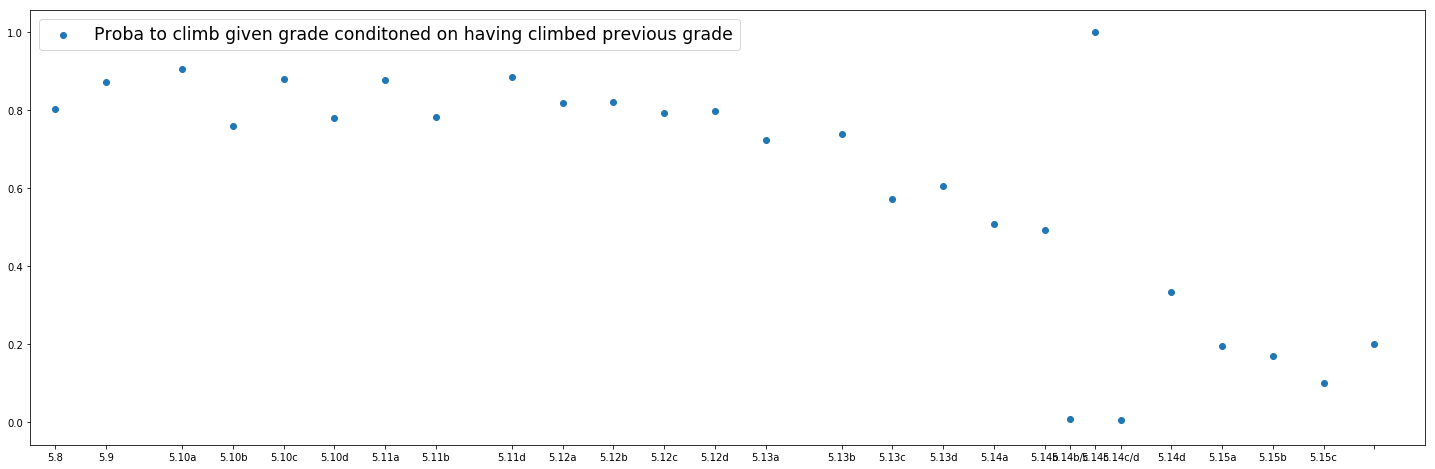

In [6]:
plt.rcParams['figure.figsize'] = [25, 8]
plt.scatter(grade, cond_proba)
plt.xticks(grade, usa_grades.iloc[1:])
plt.xlim(xmin = 30, xmax = 85)
plt.legend(['Proba to climb given grade conditoned on having climbed previous grade'], loc = 2, fontsize = 'xx-large')
plt.plot

<function matplotlib.pyplot.plot>

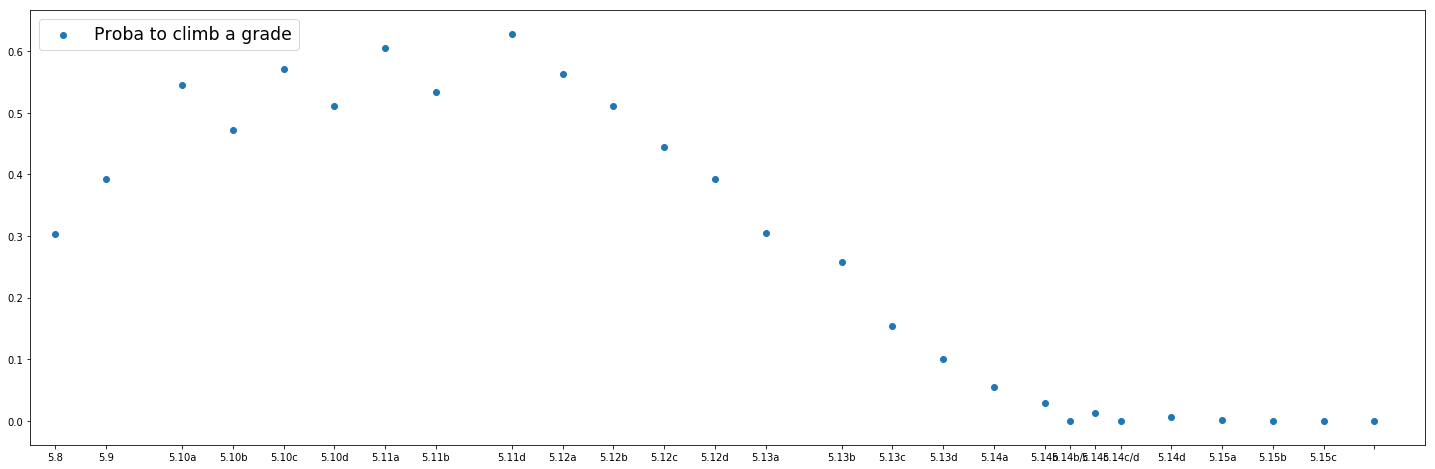

In [7]:
plt.rcParams['figure.figsize'] = [25, 8]
plt.scatter(ticks[1:], uncond_proba)
plt.xticks(ticks[1:], usa_grades.iloc[1:])
plt.xlim(xmin = 30, xmax = 85)
plt.legend(['Proba to climb a grade'], loc = 2, fontsize = 'xx-large')
plt.plot